In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import cerberus
import pyranges as pr
import upsetplot

p = os.path.dirname(os.getcwd())
sys.path.append(p)

from scripts.utils import *
from scripts.vcf_utils import *
from scripts.plotting import *

In [2]:
config = load_config()
od = '../'

def proc_cfg(entry, od):
    entry = entry.replace('../../', '')
    entry = od+entry
    return entry

In [70]:
df = load_meta()
df = df.loc[~df['sample'].str.contains('_')]
df['lab_sample'] = df['lab_number_sample'].astype(str)+'_'+\
                      df['lab_sampleid'].astype(str)+'_'+\
                      df['cell_line_id'].astype(str)
df = df[['cell_line_id', 'sample', 'hapmap_DNA_ID', 'lab_sample', 'population']].drop_duplicates()

temp_df = pd.read_csv('../snakemake/transcript_discovery_personal/cell_line_ids.txt', header=None, names=['cell_line_id'])

# make a 1000g cell line id col
df['cell_line_id_1000g'] = df.cell_line_id

inds = df.loc[~df.cell_line_id_1000g.isin(temp_df.cell_line_id.tolist())].index
df.loc[inds, 'cell_line_id_1000g'] = df.loc[inds, 'hapmap_DNA_ID']
len(df.index)

# limit to just those in 1000g
df = df.loc[df.cell_line_id_1000g.isin(temp_df.cell_line_id.tolist())]
assert len(df.index) == 30

# TODO bad sample that hasn't finished on espresso
bad_samples = ['NA19328']
df = df.loc[~df.cell_line_id_1000g.isin(bad_samples)]

hap = ['hap1', 'hap2']

meta_df = df.copy(deep=True)

In [71]:
meta_df.head()

,cell_line_id,sample,hapmap_DNA_ID,lab_sample,population,cell_line_id_1000g
0,HG04217,ITU5,no_hapmap,39_IN5_HG04217,ITU,HG04217
1,HG04216,ITU4,no_hapmap,38_IN4_HG04216,ITU,HG04216
2,HG03732,ITU3,no_hapmap,37_IN3_HG03732,ITU,HG03732
3,HG03729,ITU2,no_hapmap,36_IN2_HG03729,ITU,HG03729
4,HG03719,ITU1,no_hapmap,35_IN1_HG03719,ITU,HG03719


## Raw # ICs detected per sample per map haplotype

In [13]:
file = proc_cfg(config['lr']['td_personal']['cerb']['ic_summary'],od)
df = pd.read_csv(file)
df.drop('Unnamed: 0', axis=1, inplace=True)

# remove sqanti genome and drop dupes
# the sqanti genome SHOULD be irrelevant here
df = df.drop('sqanti_genome', axis=1)
print(len(df.index))
df = df.drop_duplicates()
print(len(df.index))

# then make sure that there are no dupe. ic+structural cat+sample+map genome
temp = df.loc[df[['ic_id', 'structural_category',
                  'cell_line_id', 'map_genome']].duplicated(keep=False)]
assert len(temp.index) == 0
del temp

# transform to be t/f for each ic per genome
df.drop('transcript_id', axis=1, inplace=True)
df_crosstab = pd.crosstab(index=[df.ic_id, df.structural_category, df.cell_line_id], 
                          columns=df.map_genome, 
                          values=df.map_genome, 
                          aggfunc=lambda x: True).fillna(False).reset_index()

In [40]:
# df.loc[df.ic_id=='GL000008.2_+_83545-83926-84014-85456-85477-85566-85625-173515']
# df_crosstab.tail()
# df_crosstab.tail().ic_id.values[3]
# df.loc[df.ic_id=='chrY_-_341306-340940-340764-338896-338777-338710-338603-334517']

{'matrix': <AxesSubplot:>,
 'shading': <AxesSubplot:>,
 'totals': <AxesSubplot:>,
 'intersections': <AxesSubplot:ylabel='Intersection size'>}

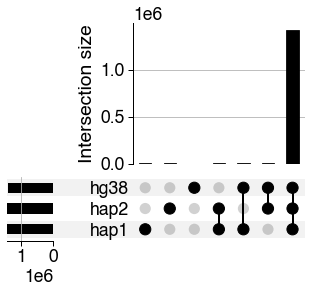

In [41]:
map_genomes = ['hg38', 'hap1', 'hap2']
df_crosstab = df_crosstab.set_index(map_genomes)

# TODO - would like this to have the total # uniq ICs bar plot
# and box plot of # ICs per sample

c_dict, order = get_novelty_colors()
init_plot_settings()
upset = upsetplot.UpSet(df_crosstab)  # disable the default bar chart
# upset = upsetplot.UpSet(df_crosstab, intersection_plot_elements=0)  # disable the default bar chart
# upset.add_stacked_bars(
#     by="structural_category", colors=c_dict, title="Count by structural category")
upset.plot()

,cell_line_id,map_genome,n_ic
0,HG00621,hap1,62854
1,HG00621,hap2,62792
2,HG00621,hg38,62241
3,HG01567,hap1,51020
4,HG01567,hap2,51027


In [64]:
# just look at raw counts differences
temp = df[['ic_id', 'cell_line_id', 'map_genome']].groupby(['cell_line_id', 'map_genome']).nunique().reset_index().rename({'ic_id':'n_ic'}, axis=1)

# do paired wilcoxon tests for each haplotype
temp = temp.pivot(index='cell_line_id', columns='map_genome', values='n_ic').reset_index()

# Wilcoxon test: hap1 vs hg38. hyp is that hap1 > hg38
stat, pval = st.wilcoxon(temp['hap1'].tolist(), temp['hg38'].tolist(), alternative='greater')
print(f"hap1 vs hg38: Wilcoxon stat = {stat}, p-value = {pval:.3f}")


# Wilcoxon test: hap2 vs hg38. hyp is that hap2 > hg38
stat, pval = st.wilcoxon(temp['hap2'].tolist(), temp['hg38'].tolist(), alternative='greater')
print(f"hap2 vs hg38: Wilcoxon stat = {stat}, p-value = {pval:.3f}")

hap1 vs hg38: Wilcoxon stat = 465.0, p-value = 0.000
hap2 vs hg38: Wilcoxon stat = 465.0, p-value = 0.000


In [85]:
temp['hap1_diff'] = temp['hap1']-temp['hg38']
temp['hap2_diff'] = temp['hap2']-temp['hg38']
temp['hap1_perc_diff'] = (temp['hap1_diff']/temp['hg38'])*100
temp['hap2_perc_diff'] = (temp['hap2_diff']/temp['hg38'])*100

In [86]:
import statistics
thing = temp.hap1_diff.tolist()+temp.hap2_diff.tolist()
statistics.median(thing)

361.5

In [87]:
import statistics
thing = temp.hap1_perc_diff.tolist()+temp.hap2_perc_diff.tolist()
statistics.median(thing)

0.8341101944024978

In [89]:
print(len(temp.loc[temp.hap1_diff<0]))
print(len(temp.loc[temp.hap2_diff<0]))

0
0


In [88]:
temp.head(9)

map_genome,cell_line_id,hap1,hap2,hg38,hap1_diff,hap2_diff,hap1_perc_diff,hap2_perc_diff
0,HG00621,62854,62792,62241,613,551,0.984881,0.885269
1,HG01567,51020,51027,50579,441,448,0.871903,0.885743
2,HG01928,43105,43112,42785,320,327,0.747926,0.764287
3,HG01952,50929,50887,50415,514,472,1.019538,0.936229
4,HG01975,48602,48646,48234,368,412,0.762947,0.854169
5,HG02261,59769,59788,59183,586,605,0.990149,1.022253
6,HG02293,40172,40139,39814,358,325,0.899181,0.816296
7,HG03719,48699,48656,48367,332,289,0.686418,0.597515
8,HG03729,52948,52922,52405,543,517,1.036161,0.986547


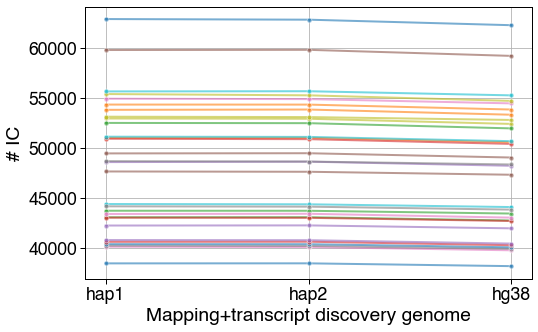

In [91]:
# visualization
init_plot_settings(aspect='square')
temp2 = temp.melt(id_vars=['cell_line_id'], 
                      value_vars=['hap1', 'hap2', 'hg38'], 
                      var_name='map_genome', 
                      value_name='n_ic')
temp2 = temp2.merge(meta_df[['cell_line_id_1000g', 'population']],
                    how='left',
                    left_on='cell_line_id',
                    right_on='cell_line_id_1000g')

# Plot
plt.figure(figsize=(8, 5))
sns.lineplot(data=temp2, x='map_genome', y='n_ic', hue='cell_line_id', marker='o', palette="tab10",
             linewidth=2, alpha=0.6, legend=False)
# plt.title("Paired Comparison of n_ic across Genomes")
plt.ylabel("# IC")
plt.xlabel("Mapping+transcript discovery genome")
plt.grid(True)
plt.show()

## Are there any differences that are bigger for different populations?

In [93]:
temp = temp.merge(meta_df[['cell_line_id_1000g', 'population']],
                    how='left',
                    left_on='cell_line_id',
                    right_on='cell_line_id_1000g')

In [96]:
temp.head()

,cell_line_id,hap1,hap2,hg38,hap1_diff,hap2_diff,hap1_perc_diff,hap2_perc_diff,cell_line_id_1000g,population
0,HG00621,62854,62792,62241,613,551,0.984881,0.885269,HG00621,HAC
1,HG01567,51020,51027,50579,441,448,0.871903,0.885743,HG01567,PEL
2,HG01928,43105,43112,42785,320,327,0.747926,0.764287,HG01928,PEL
3,HG01952,50929,50887,50415,514,472,1.019538,0.936229,HG01952,PEL
4,HG01975,48602,48646,48234,368,412,0.762947,0.854169,HG01975,PEL


/Users/fairliereese/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  


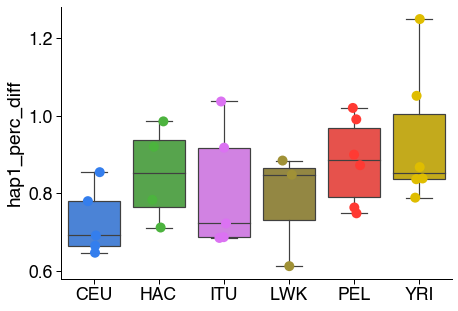

In [109]:
init_plot_settings(aspect='rectangle')
c_dict, order = get_population_colors(cats=temp.population.unique().tolist())
ax = sns.boxplot(temp,
            x='population',
            y='hap1_perc_diff',
            palette=c_dict,
            order=order, 
            saturation=0.75,
            showfliers=False)
sns.stripplot(x='population', y='hap1_perc_diff', data=temp, jitter=True,
              palette=c_dict,
              order=order,
              size=10,
              edgecolor='k')
_ = ax.set(xlabel='')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  


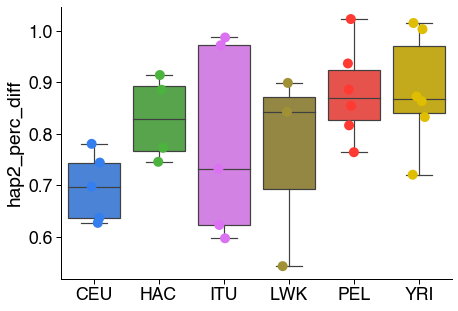

In [110]:
init_plot_settings(aspect='rectangle')
c_dict, order = get_population_colors(cats=temp.population.unique().tolist())
ax = sns.boxplot(temp,
            x='population',
            y='hap2_perc_diff',
            palette=c_dict,
            order=order, 
            saturation=0.75,
            showfliers=False)
sns.stripplot(x='population', y='hap2_perc_diff', data=temp, jitter=True,
              palette=c_dict,
              order=order,
              size=10,
              edgecolor='k')
_ = ax.set(xlabel='')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [111]:
temp.loc[temp.hap2_perc_diff==temp.hap2_perc_diff.min(axis=0)]

,cell_line_id,hap1,hap2,hg38,hap1_diff,hap2_diff,hap1_perc_diff,hap2_perc_diff,cell_line_id_1000g,population
28,NA19390,53125,53089,52802,323,287,0.611719,0.54354,NA19390,LWK


## What do gains look like in terms of different structural categories?

In [175]:
file = proc_cfg(config['lr']['td_personal']['cerb']['ic_summary'],od)
df = pd.read_csv(file)
df.drop('Unnamed: 0', axis=1, inplace=True)

# remove sqanti genome and drop dupes
# the sqanti genome SHOULD be irrelevant here
df = df.drop('sqanti_genome', axis=1)
print(len(df.index))
df = df.drop_duplicates()
print(len(df.index))

# then make sure that there are no dupe. ic+structural cat+sample+map genome
temp = df.loc[df[['ic_id', 'structural_category',
                  'cell_line_id', 'map_genome']].duplicated(keep=False)]
assert len(temp.index) == 0
del temp

# rename struct cats
sc_map = {'antisense': 'Antisense',
          'full-splice_match': 'FSM',
           'fusion': 'Fusion',
           'genic': 'Genic',
           'incomplete-splice_match': 'ISM',
           'intergenic': 'Intergenic',
           'novel_in_catalog': 'NIC',
           'novel_not_in_catalog': 'NNC'}
df.structural_category = df.structural_category.map(sc_map)


# transform to be t/f for each ic per genome
df.drop('transcript_id', axis=1, inplace=True)
df_crosstab = pd.crosstab(index=[df.ic_id, df.structural_category, df.cell_line_id], 
                          columns=df.map_genome, 
                          values=df.map_genome, 
                          aggfunc=lambda x: True).fillna(False).reset_index()

12993951
4331317


In [176]:
df.structural_category.unique()

array(['FSM', 'NNC', 'NIC', 'Fusion', 'ISM', 'Intergenic', 'Antisense',
       'Genic'], dtype=object)

[Text(0, 0, 'FSM'),
 Text(1, 0, 'ISM'),
 Text(2, 0, 'NIC'),
 Text(3, 0, 'NNC'),
 Text(4, 0, 'Intergenic'),
 Text(5, 0, 'Genic'),
 Text(6, 0, 'Fusion'),
 Text(7, 0, 'Antisense')]

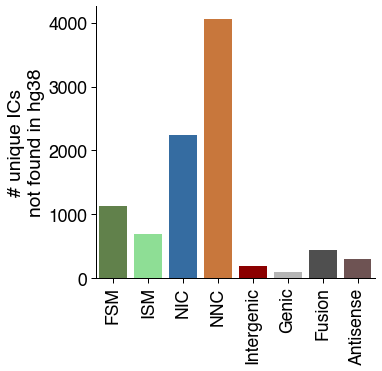

In [177]:
# get just the ics that are not detected (per sample) in hg38
temp = df_crosstab.loc[df_crosstab.hg38==False]
c_dict, order = get_novelty_colors(cats=temp.structural_category.unique().tolist())
temp = temp[['ic_id', 'structural_category']].groupby('structural_category').nunique().reset_index().rename({'ic_id':'n_ic'}, axis=1)
ax = sns.barplot(temp, x='structural_category',
                 y='n_ic',
                 palette=c_dict,
                 order=order,
                 saturation=1)
ax.set(ylabel='# unique ICs\nnot found in hg38', xlabel='')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)


In [178]:
map_genomes = ['hg38', 'hap1', 'hap2']
df_crosstab = df_crosstab.set_index(map_genomes)
df_crosstab.head()


map_genome                                                  ic_id  \
hg38 hap1 hap2                                                      
True True True  GL000008.2_+_83545-83926-84014-85456-85477-855...   
          True  GL000008.2_+_83545-83926-84014-85566-85625-129984   
          True  GL000008.2_+_83545-83926-84014-85566-85625-155...   
          True  GL000008.2_+_83545-83926-84014-85566-85625-199427   
          True   GL000008.2_+_83545-83926-84014-85566-85625-88635   

map_genome     structural_category cell_line_id  
hg38 hap1 hap2                                   
True True True                 FSM      HG01567  
          True                 FSM      HG03732  
          True                 FSM      HG03732  
          True                 FSM      HG03732  
          True                 FSM      HG01567

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


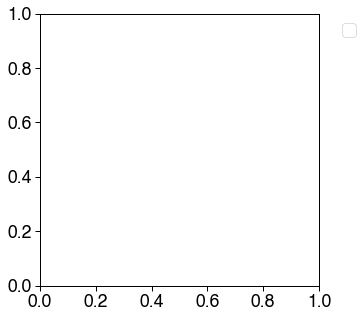

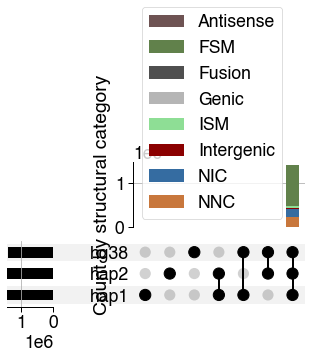

In [179]:
# TODO - would like this to have the total # uniq ICs bar plot
# and box plot of # ICs per sample
c_dict, order = get_novelty_colors()
init_plot_settings()
upset = upsetplot.UpSet(df_crosstab, intersection_plot_elements=0)  # disable the default bar chart
upset.add_stacked_bars(
    by="structural_category", title="Count by structural category",
    colors=c_dict)
ax = plt.gca()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
upset.plot()
plt.savefig('td_personal_hg38_novelty_barplot.pdf', dpi=500)

In [171]:
# remove the intersection of them all 
df_crosstab.reset_index(inplace=True)
df_crosstab = df_crosstab.loc[~(df_crosstab[map_genomes].sum(axis=1)==3)]
df_crosstab.head()

map_genome,hg38,hap1,hap2,ic_id,structural_category,cell_line_id
39,False,True,False,GL000194.1_-_114985-112838-112791-55676-55445-...,NNC,NA19390
78,False,False,True,GL000194.1_-_114985-112850-112791-55676-55445-...,NNC,HG03729
79,False,False,True,GL000194.1_-_114985-112850-112791-55676-55445-...,NNC,HG04217
118,True,False,True,GL000194.1_-_114985-112850-112791-55676-55445-...,NNC,NA12878
132,False,False,True,GL000194.1_-_114985-112850-112791-55676-55445-...,NNC,HG04217


In [172]:
map_genomes = ['hg38', 'hap1', 'hap2']
df_crosstab = df_crosstab.set_index(map_genomes)
df_crosstab.head()


map_genome                                                     ic_id  \
hg38  hap1  hap2                                                       
False True  False  GL000194.1_-_114985-112838-112791-55676-55445-...   
      False True   GL000194.1_-_114985-112850-112791-55676-55445-...   
            True   GL000194.1_-_114985-112850-112791-55676-55445-...   
True  False True   GL000194.1_-_114985-112850-112791-55676-55445-...   
False False True   GL000194.1_-_114985-112850-112791-55676-55445-...   

map_genome        structural_category cell_line_id  
hg38  hap1  hap2                                    
False True  False                 NNC      NA19390  
      False True                  NNC      HG03729  
            True                  NNC      HG04217  
True  False True                  NNC      NA12878  
False False True                  NNC      HG04217

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


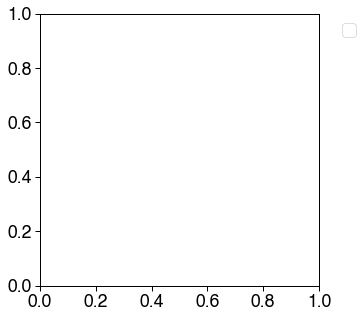

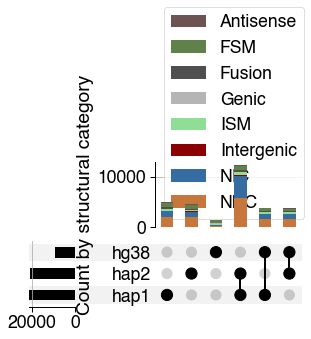

In [174]:
# TODO - would like this to have the total # uniq ICs bar plot
# and box plot of # ICs per sample



c_dict, order = get_novelty_colors()
init_plot_settings()
upset = upsetplot.UpSet(df_crosstab, intersection_plot_elements=0)  # disable the default bar chart
upset.add_stacked_bars(
    by="structural_category", title="Count by structural category",
    colors=c_dict)
ax = plt.gca()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
upset.plot()
plt.savefig('td_personal_hg38_undet_ic_novelty_barplot.pdf', dpi=500)

## Raw # ICs detected in at least one haplotype vs. hg38 (essentailly do the same as above but allow both personal genome haplotypes to contrubute

In [ ]:
# TODO

## Now look at splice junctions detection? (no sqanti yet ie dedupe sjs from sqanti_genome). Do we see more splice junctions? More novel splice junctions?

In [163]:
file = proc_cfg(config['lr']['td_personal']['sqanti']['sj_summary'],od)
df = pd.read_csv(file)
df.drop('Unnamed: 0', axis=1, inplace=True)

In [164]:
# remove sqanti genome and drop dupes
# the sqanti genome / splice motif SHOULD be irrelevant here
df = df.drop(['sqanti_genome', 'splice_motif'], axis=1)
print(len(df.index))
df = df.drop_duplicates()
print(len(df.index))

24934518
8318481


In [165]:
df.head()

,sj_id,canonical,cell_line_id,map_genome
0,KI270741.1_+_44470_47849,canonical,NA12273,hg38
1,KI270741.1_+_48008_52058,canonical,NA12273,hg38
2,KI270741.1_+_52137_130639,canonical,NA12273,hg38
3,KI270741.1_+_44470_47948,canonical,NA12273,hg38
4,GL000224.1_+_102592_105978,canonical,NA12273,hg38


In [ ]:

# # remove sqanti genome and drop dupes
# # the sqanti genome SHOULD be irrelevant here
# df = df.drop('sqanti_genome', axis=1)
# print(len(df.index))
# df = df.drop_duplicates()
# print(len(df.index))

# # then make sure that there are no dupe. ic+structural cat+sample+map genome
# temp = df.loc[df[['ic_id', 'structural_category',
#                   'cell_line_id', 'map_genome']].duplicated(keep=False)]
# assert len(temp.index) == 0
# del temp

# # rename struct cats
# sc_map = {'antisense': 'Antisense',
#           'full-splice_match': 'FSM',
#            'fusion': 'Fusion',
#            'genic': 'Genic',
#            'incomplete-splice_match': 'ISM',
#            'intergenic': 'Intergenic',
#            'novel_in_catalog': 'NIC',
#            'novel_not_in_catalog': 'NNC'}
# df.structural_category = df.structural_category.map(sc_map)


# # transform to be t/f for each ic per genome
# df.drop('transcript_id', axis=1, inplace=True)
# df_crosstab = pd.crosstab(index=[df.ic_id, df.structural_category, df.cell_line_id], 
#                           columns=df.map_genome, 
#                           values=df.map_genome, 
#                           aggfunc=lambda x: True).fillna(False).reset_index()

## Are there splice junctions that 1. uniquely detected by hap 1/2 (map_genome) and 2. are NC in hg38 (sqanti_genome)

In [185]:
file = proc_cfg(config['lr']['td_personal']['sqanti']['sj_summary'],od)
df = pd.read_csv(file)
df.drop('Unnamed: 0', axis=1, inplace=True)


,sj_id,splice_motif,canonical,cell_line_id,map_genome,sqanti_genome
0,KI270741.1_+_44470_47849,GTAG,canonical,NA12273,hg38,hg38
1,KI270741.1_+_48008_52058,GTAG,canonical,NA12273,hg38,hg38
2,KI270741.1_+_52137_130639,GTAG,canonical,NA12273,hg38,hg38
3,KI270741.1_+_44470_47948,GTAG,canonical,NA12273,hg38,hg38
4,GL000224.1_+_102592_105978,GTAG,canonical,NA12273,hg38,hg38


In [206]:
df.loc[(df.cell_line_id=='NA12273')&(df.sj_id=='KI270741.1_+_44470_47849')]

,sj_id,splice_motif,canonical,cell_line_id,map_genome,sqanti_genome
0,KI270741.1_+_44470_47849,GTAG,canonical,NA12273,hg38,hg38
86907,KI270741.1_+_44470_47849,GTAG,canonical,NA12273,hg38,hap2
173814,KI270741.1_+_44470_47849,GTAG,canonical,NA12273,hg38,hap1
8330170,KI270741.1_+_44470_47849,GTAG,canonical,NA12273,hap2,hg38
8417497,KI270741.1_+_44470_47849,GTAG,canonical,NA12273,hap2,hap2
8504824,KI270741.1_+_44470_47849,GTAG,canonical,NA12273,hap2,hap1
8581593,KI270741.1_+_44470_47849,GTAG,canonical,NA12273,hap1,hg38
8668901,KI270741.1_+_44470_47849,GTAG,canonical,NA12273,hap1,hap2
8756209,KI270741.1_+_44470_47849,GTAG,canonical,NA12273,hap1,hap1


In [ ]:
temp.loc[(temp.sj_id=='KI270741.1_+_44470_47849')&(temp.cell_line_id=='NA12273')]

In [198]:
# transform to be t/f for each ss per map / sqanti genome
# Melt the map_genome and sqanti_genome columns into long form
temp = df.melt(id_vars=['sj_id', 'cell_line_id', 'canonical'],
                  value_vars=['map_genome', 'sqanti_genome'],
                  var_name='genome_type',
                  value_name='genome')

In [199]:
# Create the new column with the "map_" or "sqanti_" prefix
temp['genome_type'] = temp['genome_type'] + '_' + temp['genome']
temp.head()

,sj_id,cell_line_id,canonical,genome_type,genome
0,KI270741.1_+_44470_47849,NA12273,canonical,map_genome_hg38,hg38
1,KI270741.1_+_48008_52058,NA12273,canonical,map_genome_hg38,hg38
2,KI270741.1_+_52137_130639,NA12273,canonical,map_genome_hg38,hg38
3,KI270741.1_+_44470_47948,NA12273,canonical,map_genome_hg38,hg38
4,GL000224.1_+_102592_105978,NA12273,canonical,map_genome_hg38,hg38


In [204]:
# make sure no dupes first
assert len(temp.loc[temp.duplicated(subset=['sj_id', 'cell_line_id', 'canonical', 'genome_type', 'genome'])]) == 0

AssertionError: 

In [205]:
temp.loc[temp.duplicated(subset=['sj_id', 'cell_line_id', 'canonical', 'genome_type', 'genome'])].sort_values(by=['sj_id', 'cell_line_id', 'canonical', 'genome_type', 'genome']).head()

,sj_id,cell_line_id,canonical,genome_type,genome
23710225,GL000008.2_+_155532_156720,HG03732,canonical,map_genome_hap1,hap1
23794042,GL000008.2_+_155532_156720,HG03732,canonical,map_genome_hap1,hap1
23504334,GL000008.2_+_155532_156720,HG03732,canonical,map_genome_hap2,hap2
23588040,GL000008.2_+_155532_156720,HG03732,canonical,map_genome_hap2,hap2
7614218,GL000008.2_+_155532_156720,HG03732,canonical,map_genome_hg38,hg38


,sj_id,splice_motif,canonical,cell_line_id,map_genome,sqanti_genome
0,KI270741.1_+_44470_47849,GTAG,canonical,NA12273,hg38,hg38
86907,KI270741.1_+_44470_47849,GTAG,canonical,NA12273,hg38,hap2
173814,KI270741.1_+_44470_47849,GTAG,canonical,NA12273,hg38,hap1
8330170,KI270741.1_+_44470_47849,GTAG,canonical,NA12273,hap2,hg38
8417497,KI270741.1_+_44470_47849,GTAG,canonical,NA12273,hap2,hap2
8504824,KI270741.1_+_44470_47849,GTAG,canonical,NA12273,hap2,hap1
8581593,KI270741.1_+_44470_47849,GTAG,canonical,NA12273,hap1,hg38
8668901,KI270741.1_+_44470_47849,GTAG,canonical,NA12273,hap1,hap2
8756209,KI270741.1_+_44470_47849,GTAG,canonical,NA12273,hap1,hap1


In [196]:
# mark all as present because this is how it works
temp['presence'] = True

In [197]:
temp.head()

,sj_id,cell_line_id,canonical,genome_type,genome,presence
0,KI270741.1_+_44470_47849,NA12273,canonical,map_genome_hg38,hg38,True
1,KI270741.1_+_48008_52058,NA12273,canonical,map_genome_hg38,hg38,True
2,KI270741.1_+_52137_130639,NA12273,canonical,map_genome_hg38,hg38,True
3,KI270741.1_+_44470_47948,NA12273,canonical,map_genome_hg38,hg38,True
4,GL000224.1_+_102592_105978,NA12273,canonical,map_genome_hg38,hg38,True


In [ ]:




# Pivot the table to get separate columns for each genome type
temp = temp.pivot_table(index=['sj_id', 'cell_line_id', 'canonical'],
                              columns='genome_type',
                              values='presence',
                              aggfunc='first',
                              fill_value=False)

# Reset index for a cleaner output
temp = temp.reset_index()

# Rename columns for clarity
temp.columns.name = None
print(temp.head())

In [ ]:
# filter for those that are 
# 1 uniquely detected by hap 1/2